# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from comp411.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'comp411/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from comp411.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from comp411.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

grid_search = [ (lr,rg) for lr in learning_rates for rg in regularization_strengths ]

for lr, rg in grid_search:
    # Create SVM 
    svm = LinearSVM()
    # Train the model with current parameters
    train_loss = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rg, num_iters=2000, verbose=False)
    # Predict values for training set
    y_train_pred = svm.predict(X_train_feats)
    # Calculate accuracy
    train_accuracy = np.mean(y_train_pred == y_train)
    # Predict values for validation set
    y_val_pred = svm.predict(X_val_feats)
    # Calculate accuracy
    val_accuracy = np.mean(y_val_pred == y_val)
    # Save results
    results[(lr,rg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.102796 val accuracy: 0.106000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.084980 val accuracy: 0.079000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.417327 val accuracy: 0.420000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.110959 val accuracy: 0.102000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.413367 val accuracy: 0.417000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.404653 val accuracy: 0.415000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.417694 val accuracy: 0.414000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.414327 val accuracy: 0.415000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.321143 val accuracy: 0.325000
best validation accuracy achieved during cross-validation: 0.420000


In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.421


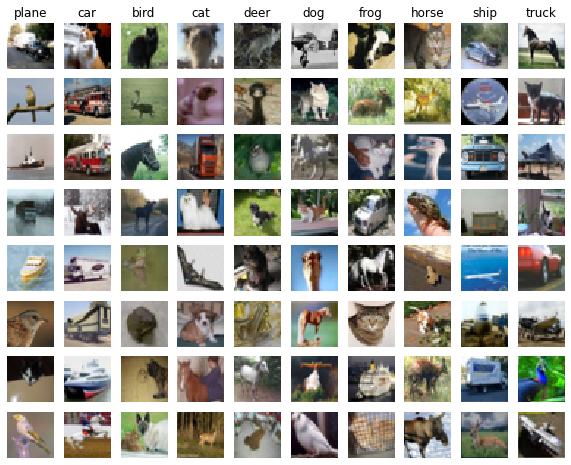

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ *I think they sometimes really make sense; for example  let X_ij corresponds to  i^th row j^th column for the images given in previous cell as 8x10 matrix. When we look at plane column, model generally misclassified bird as planes which may be make sense however the dog in X_11 and cat in X_21 looks like some outliers in that case. On the other hand for car column, i.e. 2^nd column, model generally misclassified trucks as cars which are both subcategories of vehichles which may be make sense also; but, the frog, horse and cat in X_22, X_32 and X_62 respectively are looks like high errors of model since they are not related with car category. As a result, when we want to comment our errors and misclassification: generally 70-80% of them are related sub-categories or very close objects; however other 30-20% percents are looks serious mistakes that shows model have some trouble while learning to classify these classes. (Note: sample for each run will change, so please do not think specifily for X_ij values. It was done with the first run outputs*




## Neural Network on image features
Earlier in this assigment we saw that training a three-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 58% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [8]:
from comp411.classifiers.neural_net import ThreeLayerNet

np.random.seed(1)

input_dim = X_train_feats.shape[1]
hidden_dim = 300
num_classes = 10

net = ThreeLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a three-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
best_val = -1

# Hyperparameter values
learning_rates = [1e-1, 2e-1, 2.5e-1, 3e-1, 3.5e-1, 4e-1, 1e-2, 1e-3]
regularization_strengths = [1e-4, 1e-5, 2e-5, 1e-6, 1e-7, 1e-8]
hidden_layers = [50, 100, 200, 300, 400, 500]

# Set grid search and store them in list
grid_search = [ (lr, reg, hidden_layer) for lr in learning_rates for reg in regularization_strengths for hidden_layer in hidden_layers]

# Apply grid search and store best network in best_net, store best value in best_val
for lr, reg, hidden_layer in grid_search:
    
    # Set NN and hyperparameters, then training
    net = ThreeLayerNet(input_dim, hidden_layer, num_classes)
    train_loss = net.train(X_train_feats, y_train, X_val_feats, y_val, learning_rate=lr, reg=reg, num_iters=3500, verbose=False)
    
    # Predictions of NN
    y_train_pred = net.predict(X_train_feats)
    train_accuracy = np.mean(y_train_pred == y_train)
    
    # Validation
    y_val_pred = net.predict(X_val_feats)
    val_accuracy = np.mean(y_val_pred == y_val)
    
    # Store results
    results[(lr, reg, hidden_layer)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_net = net
    print('lr %.5e reg %.5e hidden_layer %d train accuracy: %f val accuracy: %f' % (lr, reg, hidden_layer, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

lr 1.00000e-01 reg 1.00000e-04 hidden_layer 50 train accuracy: 0.100429 val accuracy: 0.079000
lr 1.00000e-01 reg 1.00000e-04 hidden_layer 100 train accuracy: 0.099735 val accuracy: 0.113000
lr 1.00000e-01 reg 1.00000e-04 hidden_layer 200 train accuracy: 0.100041 val accuracy: 0.098000
lr 1.00000e-01 reg 1.00000e-04 hidden_layer 300 train accuracy: 0.207449 val accuracy: 0.214000
lr 1.00000e-01 reg 1.00000e-04 hidden_layer 400 train accuracy: 0.263673 val accuracy: 0.260000
lr 1.00000e-01 reg 1.00000e-04 hidden_layer 500 train accuracy: 0.340184 val accuracy: 0.332000
lr 1.00000e-01 reg 1.00000e-05 hidden_layer 50 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.00000e-01 reg 1.00000e-05 hidden_layer 100 train accuracy: 0.100429 val accuracy: 0.079000
lr 1.00000e-01 reg 1.00000e-05 hidden_layer 200 train accuracy: 0.099857 val accuracy: 0.107000
lr 1.00000e-01 reg 1.00000e-05 hidden_layer 300 train accuracy: 0.198367 val accuracy: 0.207000
lr 1.00000e-01 reg 1.00000e-05 hidden_laye

lr 2.50000e-01 reg 2.00000e-05 hidden_layer 200 train accuracy: 0.607755 val accuracy: 0.548000
lr 2.50000e-01 reg 2.00000e-05 hidden_layer 300 train accuracy: 0.639469 val accuracy: 0.558000
lr 2.50000e-01 reg 2.00000e-05 hidden_layer 400 train accuracy: 0.658878 val accuracy: 0.574000
lr 2.50000e-01 reg 2.00000e-05 hidden_layer 500 train accuracy: 0.686020 val accuracy: 0.577000
lr 2.50000e-01 reg 1.00000e-06 hidden_layer 50 train accuracy: 0.303429 val accuracy: 0.314000
lr 2.50000e-01 reg 1.00000e-06 hidden_layer 100 train accuracy: 0.534184 val accuracy: 0.513000
lr 2.50000e-01 reg 1.00000e-06 hidden_layer 200 train accuracy: 0.613755 val accuracy: 0.563000
lr 2.50000e-01 reg 1.00000e-06 hidden_layer 300 train accuracy: 0.630694 val accuracy: 0.580000
lr 2.50000e-01 reg 1.00000e-06 hidden_layer 400 train accuracy: 0.668265 val accuracy: 0.584000
lr 2.50000e-01 reg 1.00000e-06 hidden_layer 500 train accuracy: 0.692490 val accuracy: 0.576000
lr 2.50000e-01 reg 1.00000e-07 hidden_lay

lr 3.50000e-01 reg 1.00000e-07 hidden_layer 400 train accuracy: 0.738490 val accuracy: 0.584000
lr 3.50000e-01 reg 1.00000e-07 hidden_layer 500 train accuracy: 0.743776 val accuracy: 0.577000
lr 3.50000e-01 reg 1.00000e-08 hidden_layer 50 train accuracy: 0.533020 val accuracy: 0.495000
lr 3.50000e-01 reg 1.00000e-08 hidden_layer 100 train accuracy: 0.624020 val accuracy: 0.565000
lr 3.50000e-01 reg 1.00000e-08 hidden_layer 200 train accuracy: 0.683041 val accuracy: 0.576000
lr 3.50000e-01 reg 1.00000e-08 hidden_layer 300 train accuracy: 0.714531 val accuracy: 0.589000
lr 3.50000e-01 reg 1.00000e-08 hidden_layer 400 train accuracy: 0.734327 val accuracy: 0.559000
lr 3.50000e-01 reg 1.00000e-08 hidden_layer 500 train accuracy: 0.746000 val accuracy: 0.578000
lr 4.00000e-01 reg 1.00000e-04 hidden_layer 50 train accuracy: 0.552612 val accuracy: 0.524000
lr 4.00000e-01 reg 1.00000e-04 hidden_layer 100 train accuracy: 0.636735 val accuracy: 0.563000
lr 4.00000e-01 reg 1.00000e-04 hidden_laye

lr 1.00000e-03 reg 1.00000e-05 hidden_layer 50 train accuracy: 0.099857 val accuracy: 0.107000
lr 1.00000e-03 reg 1.00000e-05 hidden_layer 100 train accuracy: 0.100429 val accuracy: 0.079000
lr 1.00000e-03 reg 1.00000e-05 hidden_layer 200 train accuracy: 0.099898 val accuracy: 0.105000
lr 1.00000e-03 reg 1.00000e-05 hidden_layer 300 train accuracy: 0.099898 val accuracy: 0.105000
lr 1.00000e-03 reg 1.00000e-05 hidden_layer 400 train accuracy: 0.100429 val accuracy: 0.079000
lr 1.00000e-03 reg 1.00000e-05 hidden_layer 500 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.00000e-03 reg 2.00000e-05 hidden_layer 50 train accuracy: 0.100429 val accuracy: 0.079000
lr 1.00000e-03 reg 2.00000e-05 hidden_layer 100 train accuracy: 0.100449 val accuracy: 0.078000
lr 1.00000e-03 reg 2.00000e-05 hidden_layer 200 train accuracy: 0.099959 val accuracy: 0.102000
lr 1.00000e-03 reg 2.00000e-05 hidden_layer 300 train accuracy: 0.100449 val accuracy: 0.078000
lr 1.00000e-03 reg 2.00000e-05 hidden_laye

In [9]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.565
